# Explorations in Deep Learning

In this notebook, we're going to dive into the ABC of deep learning. We will utilize the Fashion MNIST dataset, which comprises 70,000 images of fashion artifacts.

To tackle this challenge, we will implement a Multi-Layer Perceptron (MLP) that includes several hidden layers. Additionally, we will craft a convolutional neural network (CNN), which is particularly designed for handling image data.

Finally, we'll investigate how to mimic a perceptual experimental task. This will involve evaluating the resilience of our model against noise introduced into the images, to see how well it can maintain accuracy under perturbations of the input data.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm


np.set_printoptions(suppress=True)

import sklearn.metrics as metrics

import tensorflow as tf
from tensorflow import keras

2025-04-14 14:57:14.339938: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 14:57:14.340732: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 14:57:14.344688: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 14:57:14.352099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744657034.364363    6579 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744657034.36

## Loading the data

Fashion MNIST is already split into training / test sets, so we don't need to use `train_test_split`. It is also already divided between input data (pixels) and output targets (digit classes).

In [4]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.fashion_mnist.load_data()

The images are in a two dimensional format (28x28 matrices). However, the neural network requires one dimensional input vectors, thus the first step is to flatten the matrices with the function `reshape`, obtaining a vector of 784 elements.

Moreover, the images are saved in a conventional format, where each pixel can assume values between 0 and 255. Hence, the second step is to normalize such values to a 0-1 interval, simply by dividing by 255.

In [5]:
train_images.shape

(60000, 28, 28)

In [6]:
# Comvert to float32 and standardize
train_images = train_images.astype(np.float32).reshape(60000, 28 * 28)
test_images = test_images.astype(np.float32).reshape(10000, 28 * 28)

train_images = train_images / 255
test_images = test_images / 255


Visualizing the first 36 test images:

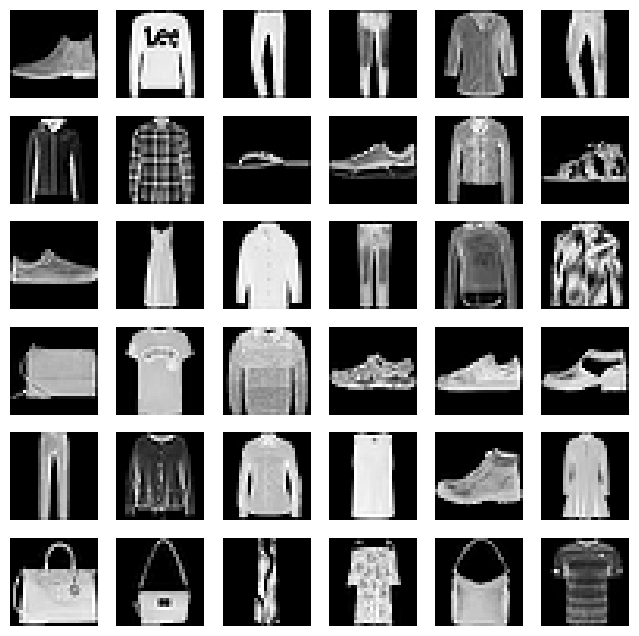

In [7]:
fig, axarr = plt.subplots(6, 6, figsize=(8, 8))
for i, ax in enumerate(axarr.flat):
    ax.imshow(test_images[i].reshape(28, 28), cmap="gray")
    ax.axis('off')

## Feedforward Network Architecture

First, we will use the keras high-level API. Then, we will re-do the task with the tensorflow low-level API.

### Model Setup

In [ ]:
# Basic feedforward structure
### Your code here
model = None


# Compile 
### Your code here

In [ ]:
# Fitting the model
### Your code here

### Visualize Loss Trajectory

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.plot(range(20), h.history['val_loss'], 'o-', color='maroon', label='Validation')
ax.plot(range(20), h.history['loss'], 'o-', color='black', label='Training')
ax.set_xlabel('Epoch')
ax.set_ylabel('Cross-entropy')
ax.legend()
ax.set_title('Loss Trajectory')
sns.despine(ax=ax)

In [ ]:
# Evaluate model on test data
test_loss, test_accuracy = model.evaluate(test_images, test_labels)

313/313 [==============================] - 0s 1ms/step - loss: 0.3496 - sparse_categorical_accuracy: 0.8886


313/313 [==============================] - 0s 1ms/step


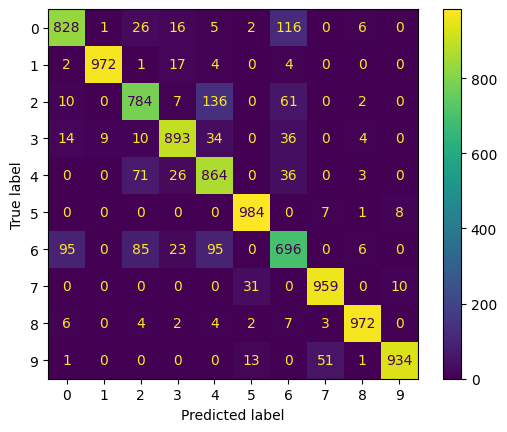

In [ ]:
# More detailed evaluations
preds = model.predict(test_images)
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, preds.argmax(axis=1))

## Custom Training Loop

### Model and Hyperparameters

In [8]:
# Create a TF data set
dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
dataset = dataset.shuffle(buffer_size=train_images.shape[0])
dataset = dataset.batch(32)

# Create loss object
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

# Create optimizer
optimizer = tf.keras.optimizers.Adam(1e-4)

# Create basic feedforward model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
])

W0000 00:00:1744657087.061667    6579 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


### Custom Training Step

In [9]:
@tf.function
def update_step(batch_images, batch_labels, model, optimizer, loss_fn):
    with tf.GradientTape() as tape:


        ### Forward pass
        batch_preds = model(batch_images)

        ### Compute loss
        loss = loss_fn(batch_labels, batch_preds)

    ### Compute gradients w.r.t batch loss
    grads = tape.gradient(loss, model.trainable_variables)

    ### Update trainable parameters
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss

### Custom Epoch

In [ ]:
def train_epoch(dataset, model, optimizer, loss_fn, pbar):
    losses = []
    for (batch_img, batch_labels) in dataset:
        noise_level = np.random.rand() / 2
        noisy_img = batch_img + noise_level * np.random.normal(size=batch_img.shape)
        loss = update_step(noisy_img, batch_labels, model, optimizer, loss_fn)
        losses.append(loss.numpy())
        pbar.set_postfix_str(f'Loss: {loss.numpy():.3f}', refresh=False)
        pbar.update(1)
    return losses

### Custom Training

In [11]:
epochs = 20
for ep in range(1, epochs+1):
    with tqdm(total=len(dataset), desc=f"Training epoch {ep}", mininterval=0.1) as pbar:
        l = train_epoch(dataset, model, optimizer, loss_fn, pbar)

Training epoch 1:   0%|          | 0/1875 [00:00<?, ?it/s]

2025-04-14 14:58:27.264445: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training epoch 2:   0%|          | 0/1875 [00:00<?, ?it/s]

2025-04-14 14:58:36.743969: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training epoch 3:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/1875 [00:00<?, ?it/s]

2025-04-14 14:58:56.425698: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training epoch 5:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 6:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 7:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 8:   0%|          | 0/1875 [00:00<?, ?it/s]

2025-04-14 14:59:35.189840: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training epoch 9:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 10:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 11:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 12:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 13:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 14:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 15:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 16:   0%|          | 0/1875 [00:00<?, ?it/s]

2025-04-14 15:00:58.048503: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training epoch 17:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 18:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 19:   0%|          | 0/1875 [00:00<?, ?it/s]

Training epoch 20:   0%|          | 0/1875 [00:00<?, ?it/s]

In [12]:
# More detailed evaluations
### Your code here
preds = model.predict(test_images)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


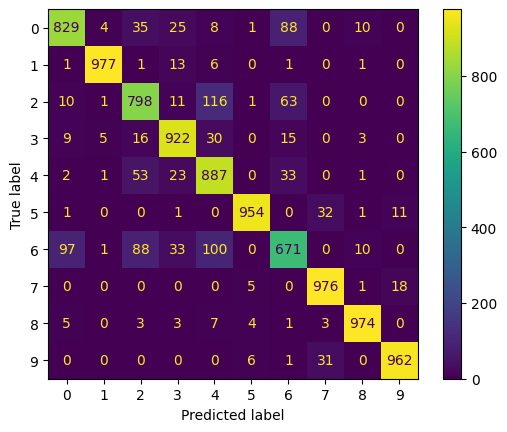

In [13]:
metrics.ConfusionMatrixDisplay.from_predictions(test_labels, preds.argmax(axis=1))

In [16]:
np.sum(preds.argmax(axis=1) == test_labels) / test_labels.shape[0]

0.895

## Explorations in Robustness

We will now explore an important question regarding the real-world pitfalls of model deployment: What is the impact of additive noise on recognition accuracy? We will systematically investigate this effect by creating a psychometric function where accuracy is plotted against stimulus visibility / noise level.

In [17]:
min_noise_level = 0
max_noise_level = 0.5
num_noise_levels = 50
noise_levels = np.linspace(min_noise_level, max_noise_level, num_noise_levels)

Let's investigate the impact of noise levels on image quality first.

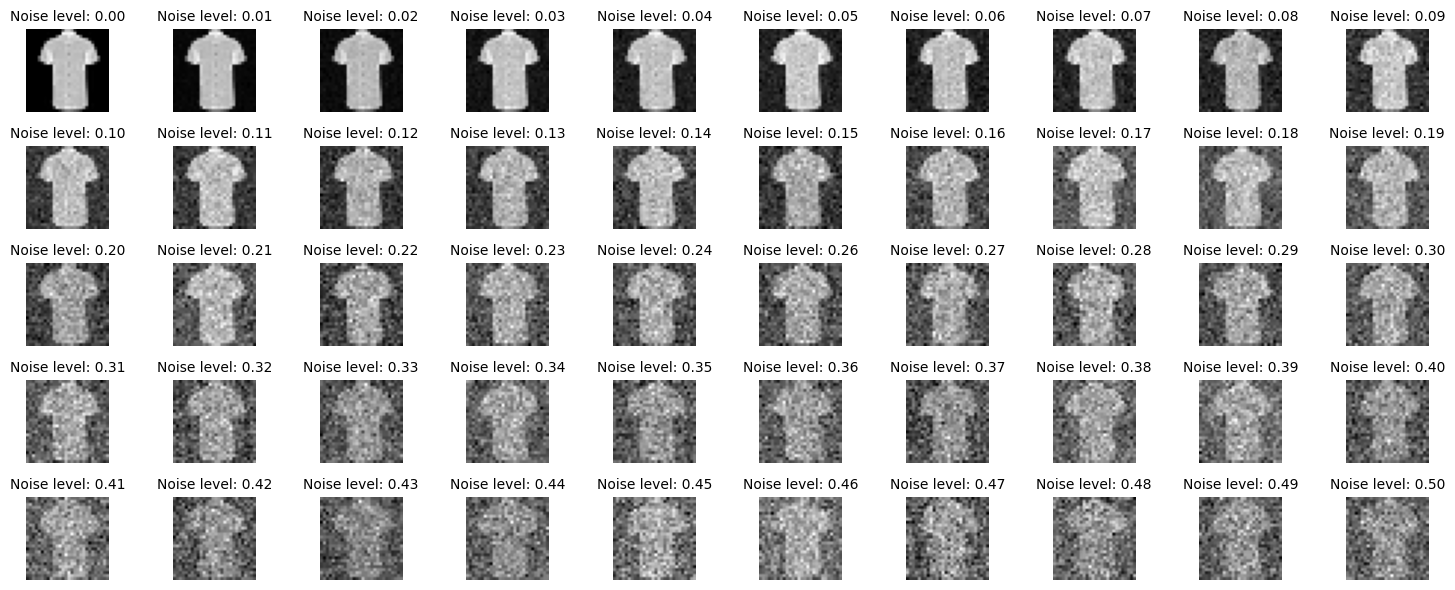

In [18]:
f, axarr = plt.subplots(5, 10, figsize=(15, 6))
random_test_image = train_images[np.random.randint(0, train_images.shape[0])]
for noise_level, ax in zip(noise_levels, axarr.flat):
    noisy_images = random_test_image + noise_level * np.random.normal(size=random_test_image.shape)
    ax.imshow(noisy_images.reshape(28, 28), cmap='gray')
    ax.set_title(f'Noise level: {noise_level:.2f}', fontsize=10)
    ax.axis('off')
f.tight_layout()

We will now iteratively add Gaussian noise with different amplitude to the test set and compute total accuracy.

In [19]:
accuracies = []
for noise_level in noise_levels:
    corrupted_images = test_images + noise_level * np.random.normal(size=test_images.shape)
    preds = model.predict(corrupted_images)
    accuracy = (preds.argmax(1) == test_labels).sum() / test_labels.shape[0]
    accuracies.append(accuracy)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━

What do you observe?

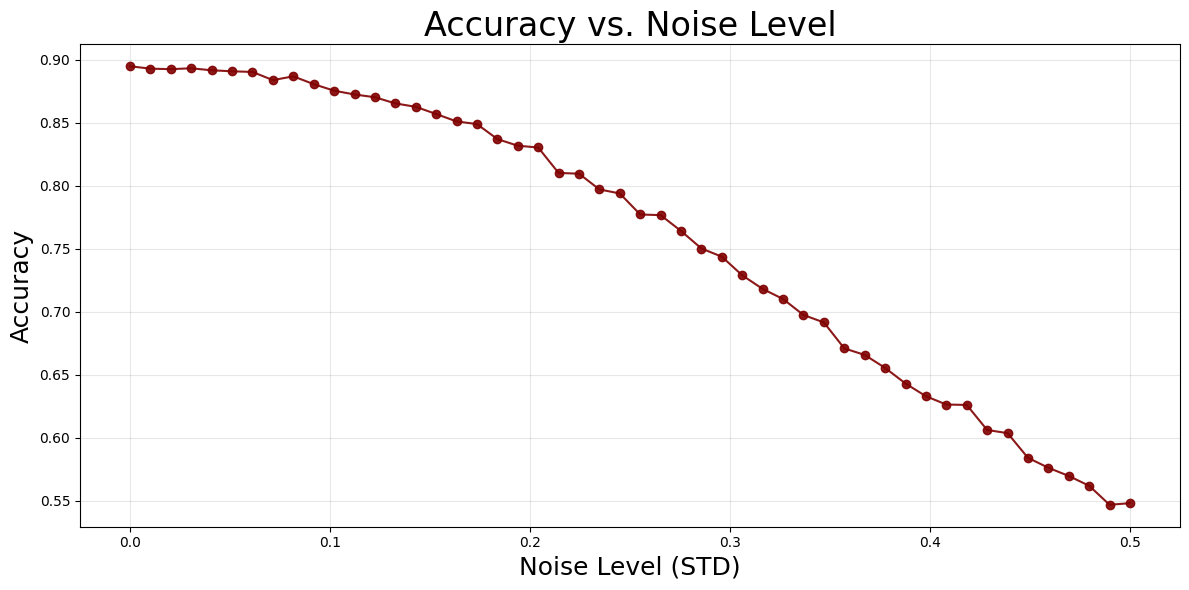

In [20]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(noise_levels, accuracies, '-o', color='maroon', alpha=0.9)
ax.set_xlabel('Noise Level (STD)', fontsize=18)
ax.set_ylabel('Accuracy', fontsize=18)
ax.set_title('Accuracy vs. Noise Level', fontsize=24)
ax.grid(alpha=0.3)
f.tight_layout()

## Task: Data Augmentation

Is it possible to improve recognition accuracy on the test set by injecting noise into the training data? 

Your task is to train the same neural network on augmented (noisy data) and plot its psychometric function relative to the vanilla model. There are many ways to do this!

In [ ]:
### Your code here


## Task: Coging Convolutional

Your code here.